In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [2]:
def count(text):
    return len(text.split())
def high_score(i):
    if i>3:
        return 1
    else: return 0

In [3]:
swords = stopwords.words('russian')

In [4]:
stem = SnowballStemmer('russian')

In [5]:
df = pd.read_csv('./wb_school_task_2.csv.gzip', compression='gzip')

In [6]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


In [7]:
df['w_count'] = df.text.apply(count)
df['h_score'] = df.f3.apply(high_score)

In [8]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,w_count,h_score
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0,15,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1,15,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0,4,1
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1,11,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0,8,1


In [9]:
print(df.w_count.corr(df.f3))
print(df.w_count.corr(df.f6))
print(df.w_count.corr(df.label))
print(df.f1.corr(df.f2))
print(df.f4.corr(df.f5))
print(df.f7.corr(df.f8))
print(df.f3.corr(df.f6))

-0.1594446928731956
-0.13470031922346318
0.10625062932826536
0.8282539894133428
0.8444491542527469
0.5753447931269051
0.4647755085596614


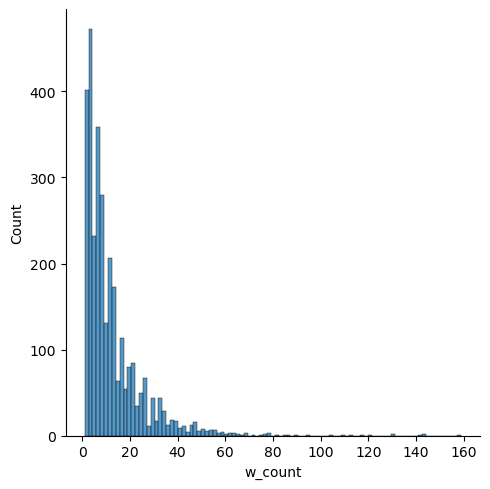

In [10]:
sns.displot(df.w_count)

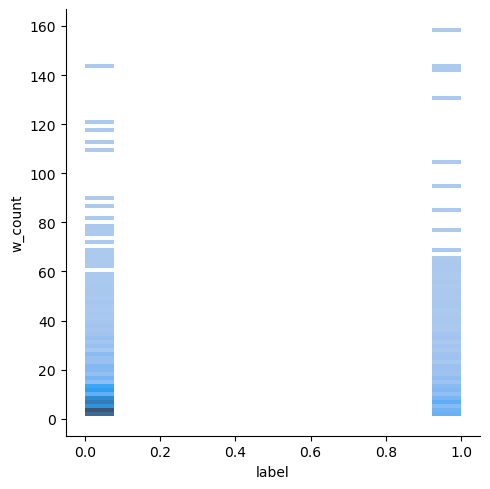

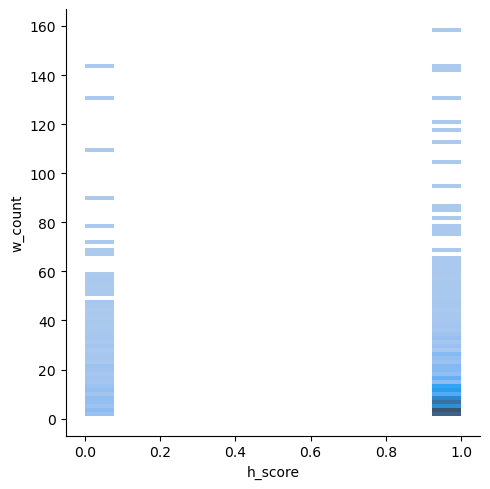

In [11]:
sns.displot(df, y='w_count', x='label')
sns.displot(df, y='w_count', x='h_score')

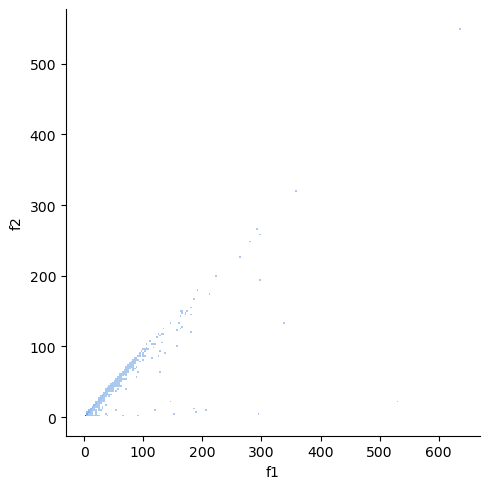

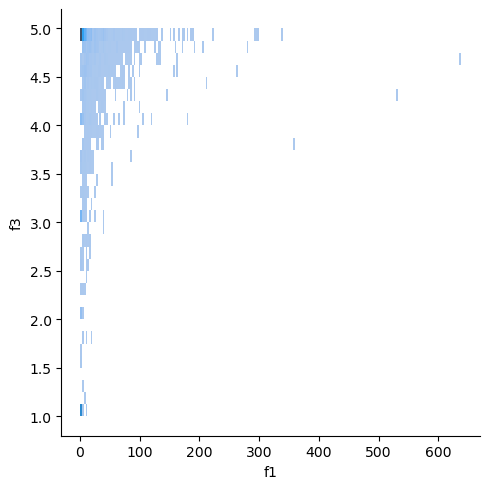

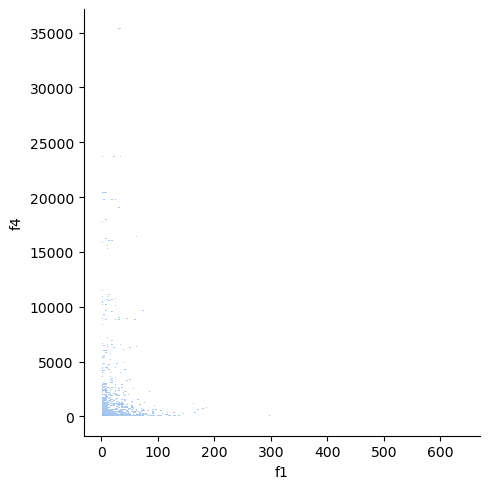

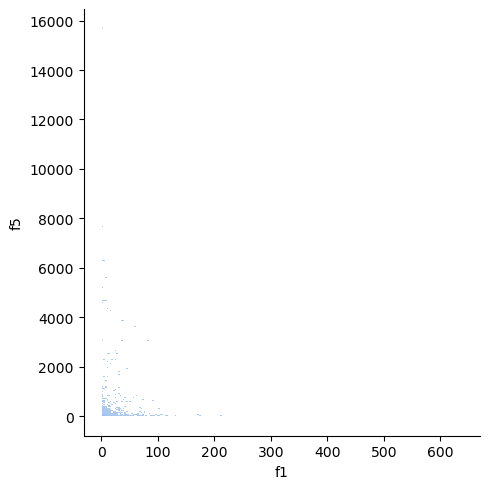

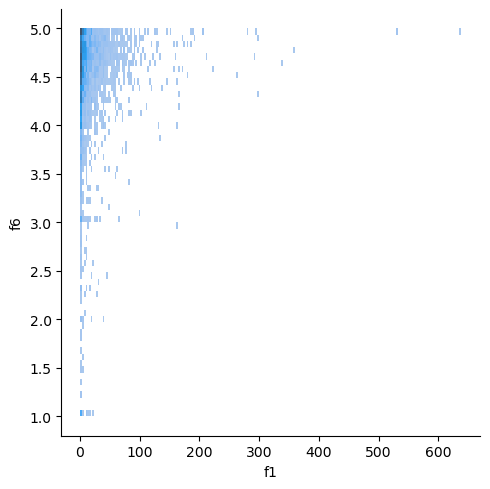

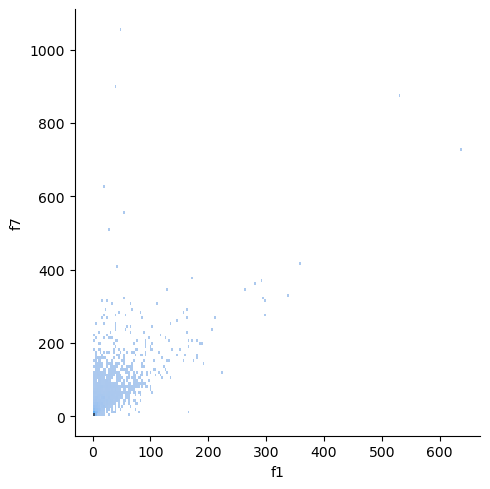

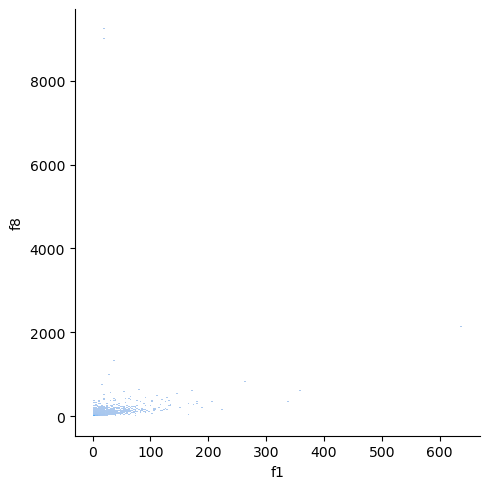

In [12]:
sns.displot(df, x='f1', y='f2')
sns.displot(df, x='f1', y='f3')
sns.displot(df, x='f1', y='f4')
sns.displot(df, x='f1', y='f5')
sns.displot(df, x='f1', y='f6')
sns.displot(df, x='f1', y='f7')
sns.displot(df, x='f1', y='f8')

In [13]:
df.loc[df['f1'] > 500]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,w_count,h_score
57,8169272926386961611,18040562023416977861,16940831933287161398,Шикарная сумка! Еще и с инструментом! Взяла ба...,638,550,4.711599,5,1,5.0,731,2137,1,13,1
93,283707312858959120,13175786626800344327,16089087977100319143,"Толстый флис ,фирма ТВОЁ. Широкие, большимерят.",530,23,4.349057,1,0,5.0,873,2123,1,6,1
283,283707312858959120,18337712866225462969,3260081402716394163,"Натуральная кожа,на узкую ногу.",530,23,4.349057,1,0,5.0,873,2123,1,4,1
985,283707312858959120,11556255111361080256,3033520687525129327,Обычный кошелек. Пришел в обычном полиэтиленов...,530,23,4.349057,1,0,5.0,873,2123,1,12,1


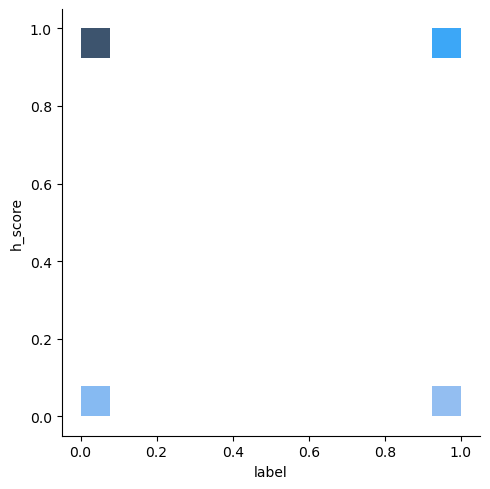

In [14]:
sns.displot(df, y='h_score', x='label')

In [15]:
df[df.duplicated(subset = ['id2'])].index

Int64Index([  46,   73,  368,  413,  564,  596,  612,  629,  630,  631,
            ...
            2992, 2993, 3000, 3022, 3046, 3049, 3054, 3083, 3085, 3101],
           dtype='int64', length=117)

In [16]:
df.loc[df['id2'] == df.id2[3085]].head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,w_count,h_score
756,1076575605779048698,3345344880097563888,14918306419713499452,"Заказала 02 оттенок, фотографии приложу) Значи...",8,8,4.750000,20419,4690,4.67878,74,108,0,20,1
757,13687420362999564220,3345344880097563888,14918306419713499452,консилер хороший советую!,6,6,3.333333,20419,4690,4.67878,6,6,0,3,1
1723,13823627268069149155,3345344880097563888,14918306419713499452,цвет не подошёл,1,1,4.000000,20419,4690,4.67878,12,17,0,3,1
3085,17564680862523094259,3345344880097563888,14918306419713499452,огонь!!!!!,7,7,4.857143,20419,4690,4.67878,24,24,0,1,1


id2 - id товара

In [17]:
df[df.duplicated(subset = ['id3'])].index

Int64Index([  26,   43,   46,   47,   48,   49,   50,   54,   62,   68,
            ...
            3110, 3111, 3112, 3113, 3116, 3117, 3118, 3119, 3120, 3121],
           dtype='int64', length=2145)

In [18]:
df.loc[df['id3'] == df.id3[26]].head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,w_count,h_score
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1,11,1
26,7274621338731644697,3340034334621716454,13541353053200353836,"Давно мечтала купить духи Может быть, и осуще...",10,10,5.000000,205,23,3.570732,22,41,0,12,1
449,14961753110682845321,1750141881488684864,13541353053200353836,Спасибо большое за духи. Африканский бал это п...,2,1,5.000000,200,71,4.680000,2,3,1,30,1
484,5797421081196931967,15046622569461799340,13541353053200353836,Всё отлично. Пришёл полностью запечатанным. За...,9,6,5.000000,203,35,4.768473,10,14,1,7,1
697,1768770341539716364,2430568197847501334,13541353053200353836,Парфюм очень качественные. Порадовал себя. Боя...,12,5,4.666667,2,0,5.000000,6,17,1,13,1


In [19]:
df[df.duplicated(subset = ['id1'])].index

Int64Index([  46,   70,   75,   79,  145,  160,  184,  199,  221,  230,  233,
             239,  251,  268,  269,  278,  283,  327,  343,  349,  402,  433,
             438,  448,  542,  818,  927,  985, 1062, 1157, 1514, 1529, 1533,
            1534, 1572, 1739, 1744, 1781, 1822, 1836, 1939, 1940, 1964, 2007,
            2085, 2150, 2185, 2244, 2245, 2247, 2347, 2399, 2450, 2489, 2540,
            2554, 2556, 2557, 2561, 2611, 2614, 2633, 2652, 2732, 2746, 2755,
            2770, 2790, 2831, 2837, 2854, 3014, 3020, 3090],
           dtype='int64')

In [20]:
df.loc[df['id1'] == df.id1[75]]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,w_count,h_score
41,5002269436549863957,8537018422111626685,2452047199270097551,"Сзади шнуровка , внутри мех и внешне выглядит ...",40,2,5.0,4,6,4.500000,13,43,1,14,1
75,5002269436549863957,13669343433924914553,2452047199270097551,"Мне подошли размер в размер. Бежевые ,смотрятс...",40,2,5.0,6,9,3.666667,13,43,1,11,1
79,5002269436549863957,11253309069675330304,2452047199270097551,Мне подошли размер в размер. Легко надела . Уд...,40,2,5.0,8,9,4.250000,13,43,1,12,1
145,5002269436549863957,12540256564528009708,2452047199270097551,Хороши на холодную слякотную погоду. Смотрятся...,40,2,5.0,4,5,4.250000,13,43,0,18,1
233,5002269436549863957,4707051732118680101,2452047199270097551,Вот такие классные ботиночки из натуральной за...,40,2,5.0,8,6,4.875000,13,43,1,16,1
327,5002269436549863957,17163190472521893796,7715615707067664181,Понравились- качество достойное! Мне подошли н...,40,2,5.0,8,6,4.500000,13,43,1,8,1
438,5002269436549863957,7184918404601862719,11037372112584364428,"Размер в размер плотно сели, но натуральная ко...",40,2,5.0,5,6,4.800000,13,43,0,15,1
542,5002269436549863957,2918697925375352353,2452047199270097551,"Меня привлекло ,то как сделана подошва, можно ...",40,2,5.0,19,17,4.368421,13,43,0,31,1
818,5002269436549863957,7793738754320529137,815378434367114826,Сумка сыну понравилась! Качество хорошее. Брак...,40,2,5.0,2,2,5.000000,13,43,1,8,1
1062,5002269436549863957,8779533373574352561,2452047199270097551,"Хорошие ботинки,удобные,смотрятся брутально. Н...",40,2,5.0,16,14,4.875000,13,43,1,6,1


id1 - id пользовтаеля

In [21]:
text = df.text

In [22]:
text[0]

'Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.'

# Первичная обработка

In [23]:
tokenized_sw_p = pd.Series([nltk.word_tokenize(text[i], language='russian') for i in range(0, len(text))])

In [24]:
tokenized_sw_p.head()

0    [Хотела, купить, на, замену, старых, ,, по, ит...
1    [Запах, по, сравнению, с, обычным, DOVE, никак...
2            [Кабель, подошёл, ,, хорошо, работает, .]
3    [Восторг, !, Очень, приятный, аромат, ,, держи...
4    [Визуально, все, хорошо, ., Не, пробовали, ., ...
dtype: object

In [25]:
stemmed = []
for i in range(0, len(tokenized_sw_p)):
    stemmed.append([stem.stem(token) for token in tokenized_sw_p[i] if token not in swords and token not in punctuation])
stemmed = pd.Series(stemmed)

In [26]:
del tokenized_sw_p
del text

In [28]:
for i in range(0, len(stemmed)):
    stemmed[i] = " ".join(stemmed[i])

0    хотел куп замен стар итог ужаснотуп удобн рвут...
1    зап сравнен обычн DOVE никак он парфюмирова то...
2                                 кабел подошел работа
3    восторг очен приятн аромат держ долг очен удоб...
4                      визуальн не пробова куп подарок
dtype: object

In [39]:
words_p = []
words_n = []
for i in df.loc[df['h_score'] == 1].index:
    words_p += Counter(stemmed[i].split())
for i in df.loc[df['h_score'] == 0].index:
    words_n += Counter(stemmed[i].split())

In [40]:
Counter(words_p).most_common(10)

[('очен', 471),
 ('отличн', 445),
 ('хорош', 444),
 ('спасиб', 314),
 ('все', 305),
 ('пришл', 248),
 ('понрав', 233),
 ('качеств', 227),
 ('размер', 202),
 ('рекоменд', 180)]

In [41]:
Counter(words_n).most_common(10)

[('пришл', 102),
 ('товар', 95),
 ('пришел', 82),
 ('возврат', 71),
 ('не', 63),
 ('очен', 55),
 ('качеств', 50),
 ('размер', 49),
 ('эт', 44),
 ('так', 42)]

In [60]:
trigram_p = ngrams(words_p, 3)
bigram_p = ngrams(words_p, 2)
trigram_n = ngrams(words_n, 3)
bigram_n = ngrams(words_n, 2)

In [61]:
Counter(trigram_p).most_common(10)

[(('пришл', 'все', 'цел'), 8),
 (('за', 'так', 'цен'), 8),
 (('спасиб', 'быстр', 'доставк'), 7),
 (('все', 'отличн', 'упакова'), 6),
 (('к', 'качеств', 'претенз'), 6),
 (('мне', 'очен', 'понрав'), 6),
 (('к', 'покупк', 'рекоменд'), 6),
 (('не', 'подошел', 'размер'), 5),
 (('пришл', 'очен', 'быстр'), 5),
 (('все', 'соответств', 'описан'), 5)]

In [62]:
Counter(bigram_p).most_common(10)

[(('очен', 'понрав'), 69),
 (('все', 'отличн'), 55),
 (('очен', 'хорош'), 41),
 (('пришл', 'цел'), 41),
 (('качеств', 'хорош'), 37),
 (('хорош', 'качеств'), 36),
 (('спасиб', 'больш'), 35),
 (('спасиб', 'продавц'), 35),
 (('все', 'цел'), 33),
 (('соответств', 'описан'), 30)]

In [58]:
Counter(trigram_n).most_common(10)

[(('100', 'рубл', 'возврат'), 4),
 (('списа', '100', 'рубл'), 3),
 (('пришл', 'та', 'модел'), 3),
 (('не', 'подошел', 'размер'), 3),
 (('не', 'соответств', 'заявлен'), 3),
 (('снял', '100', 'рубл'), 3),
 (('присла', 'друг', 'модел'), 2),
 (('заказыва', '2', 'размер'), 2),
 (('что', 'эт', 'так'), 2),
 (('нужн', 'не', 'оригина'), 2)]

In [63]:
Counter(bigram_n).most_common(10)

[(('товар', 'пришел'), 19),
 (('пункт', 'выдач'), 16),
 (('100', 'рубл'), 13),
 (('ещ', 'возврат'), 6),
 (('пришел', 'брак'), 6),
 (('не', 'рекоменд'), 6),
 (('пришел', 'товар'), 6),
 (('плох', 'качеств'), 6),
 (('не', 'соответств'), 6),
 (('хорош', 'качеств'), 5)]

In [31]:
DTC = DecisionTreeClassifier()

In [32]:
vec = TfidfVectorizer()

In [33]:
X = vec.fit_transform(stemmed)
y = df.label

In [34]:
crval = cross_val_score(DTC, X, y, cv = KFold(n_splits=5), scoring='precision')

In [35]:
crval

array([0.30534351, 0.35      , 0.296     , 0.3359375 , 0.32258065])